# Creating Synthetic Data with Copulas

## Introduction
Here, we take a look at the daily returns from Apple and Microsoft stock, visualize their KDEs, and try to synthesize some data through the Gaussian copula. Very non-rigorously, a copula takes a bunch of individual distributions and couples (hence the name) them together into a joint multivariate distribution.


### What is a Copula?
Please ignore this part if not comfortable with math.

According to Wikipedia, a marginal distribution of a subset of a collection of random variables is the probability distribution of the variables contained in the subset.

According to Wikipedia again, a copula is a multivariate cumulative distribution function for which the marginal probability distribution of each variable is uniform on the interval [0, 1].

How does it differ from a multivariate distribution? This link (https://stats.stackexchange.com/questions/61956/difference-between-multivariate-standard-normal-distribution-and-gaussian-copula) offers some insight. The Gaussian copula is the joint CDF for (uniform) random variables $u, v, w,...$, where $\Phi$ is the normal CDF, for when $(\Phi^{-1}(u), \Phi^{-1}(v), \Phi^{-1}(w), ...)$ are multivariate normal. 

Sklar's Theorem states the following. Let $H$ be a joint (cumulative) distribution function with margins $F$ and $G$. Then there exists a copula $C$ such that for all $x,y \in \mathbb{R}, H(x,y) = C(F(x), G(y))$.
It follows that replacing the $\Phi$ with CDFs of our choosing lets us construct multivariate distributions (that are not necessarily multivariate normal) distributed to our liking, with the aforementioned copula.


That is, when $C_R^{Gaussian}(u) = \Phi_R(\Phi^{-1}(u_1), ..., \Phi^{-1}(u_n))$, where $R$ is the correlation matrix, $\Phi$ is the normal CDF, and $u_1, ..., u_n$ ~ $U(0,1)$, we can replace $\Phi^{-1}$ with any inverse CDF for any distribution of our liking ($F^{-1}, G^{-1}, ...$), and get a multivariate distribution that is not necessarily normal.


### What we're doing here
To create synthetic data, we draw samples from a suitably-correlated multivariate normal distribution, apply the probability integral transform (the CDF of our normal distribution) to find uniform marginals, and apply the inverse CDF of the Laplace distributions we've fitted our stock data to to find synthetic stock returns. 

The approach is shown in Thomas Wiecki's excellent article linked to below, and elegantly described in user `cardinal`'s reply to the question here (https://stats.stackexchange.com/questions/37424/how-to-simulate-from-a-gaussian-copula). Elegantly,

Generate $(X,Y)$∼$N(0,\Sigma)$. Take $F^{−1}(\Phi(X))$ and $G^{−1}(\Phi(Y))$.

Note that with the Gaussian copula, you usually go the other way, applying the inverse CDF to each random variable, and then taking them all in as arguments to a joint CDF with covariance matrix equal to the correlation matrix between the random variables.

The code here mostly comprises material from a wonderful article by Thomas Wiecki found here (https://twiecki.io/blog/2018/05/03/copulas/), and a sanity check from a python library for copulas (https://pypi.org/project/copulas/). It can be thought of an application of the former. The very nice workaround for the multiple jointplots was by a user on StackOverflow called CT Zhu, found here (https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot).

A large part of the reason for this was to make sure I understood what was going on when reading about copulas. 

### Outline
An outline for this notebook is:
1. Importing data from Yahoo Finance
2. Fitting data to multiple distributions with Fitter
3. Visualizing the Probability Integral Transform
4. Visualizing the KDE for our stock data
5. Generating synthetic data with the Gaussian Copula

We first import all our necessary libraries.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from copulas.datasets import sample_trivariate_xyz
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d

import seaborn as sns
from scipy import stats
from pandas_datareader import data
import pandas as pd
import fitter
from fitter import Fitter

## Importing Data from Yahoo Finance
We take data from 2000 to 2020, isolate the adjusted closing prices, filter it to only take weekday stock prices, fill 'NA' entries with the previous price, and calculate percentage returns. Apple returns are stored in `returns`, and Microsoft returns are stored in `returns_ms`.

In [2]:
#getting apple prices
start_date = '2000-01-01'
end_date = '2020-11-27'

all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

panel_data = data.DataReader('AAPL', 'yahoo', start_date, end_date)
returns = panel_data['Adj Close'].reindex(all_weekdays).fillna(method='ffill').pct_change().dropna()

panel_data = data.DataReader('MSFT', 'yahoo', start_date, end_date)
returns_ms = panel_data['Adj Close'].reindex(all_weekdays).fillna(method='ffill').pct_change().dropna()

## Finding a Nicely-Fitting Distribution
We use the `fitter` library to examine how our data fits the normal, t and Laplace distributions. We find that in both cases, the Laplace distribution works best.

,sumsquare_error,aic,bic,kl_div
laplace,25.912726,1969.359450,-29158.257860,inf
t,53.437312,775.982092,-25202.184674,inf
cauchy,71.206424,393.810856,-23645.088147,inf
norm,312.760408,10905.464523,-15573.962354,inf


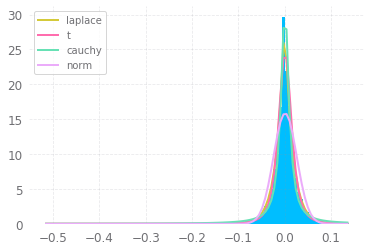

In [3]:
#fitting to distributions
f = Fitter(returns, distributions = ['norm', 't', 'laplace', 'cauchy'])
f.fit()
f.summary()

,sumsquare_error,aic,bic,kl_div
laplace,68.215779,695.496202,-23879.103740,inf
t,158.629942,345.685770,-19267.878933,inf
cauchy,175.963166,142.610060,-18710.899911,inf
norm,932.132411,2302.735520,-9617.990103,inf


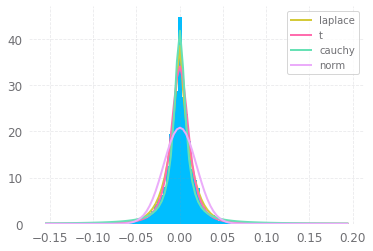

In [4]:
f = Fitter(returns_ms, distributions = ['norm', 't', 'laplace', 'cauchy'])
f.fit()
f.summary()

## Visualizing the Probability Integral Transform

We'll explain this after providing some motivation here. We have our data, and think it follows a Laplace distribution.  Let's see what happens when we apply the CDF to it. If it ends up looking like a uniform distribution, then the Laplace distribution was probably a good guess.

To do so, we first fit our data to the Laplace distribution. We then apply the CDF, and plot a histogram of our transformed returns, and see that it somewhat resembles a uniform distribution for AAPL -- except for that spike around 0%, and not at all for MSFT. That's not so great, and we can guess that our synthetic MSFT data that we will generate will probably not be as accurate.

We could've foreseen this, as we did see earlier that the SSE when fitting a Laplace distribution to MSFT is higher than that when doing the same to AAPL. 

But how did applying the CDF to our data give something that looks uniform? Why even apply the CDF? What's happening here? Why are we doing this again? Let's dive a little deeper, and see what happens with AAPL.

(0.00012197371683521969, 0.016570157684365185)
(6.732095825640109e-09, 0.012449993593411868)


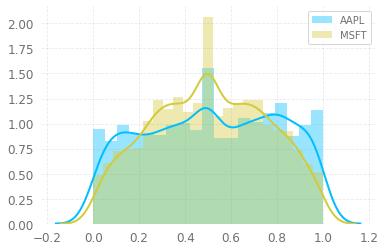

In [5]:
#fitting to laplace distribution
params = stats.distributions.laplace.fit(returns)
laplace = stats.distributions.laplace(params[0], params[1])
print(params)

returns_trans = laplace.cdf(returns)
p1 = sns.distplot(returns_trans, label = 'AAPL')

params_ms = stats.distributions.laplace.fit(returns_ms)
laplace_ms = stats.distributions.laplace(params_ms[0], params_ms[1])
print(params_ms)

returns_ms_trans = laplace.cdf(returns_ms)
p2 = sns.distplot(returns_ms_trans, label = 'MSFT')
plt.legend()

### Transforming to a Uniform Distribution with the CDF
It turns out that using the CDF, we can transform data modeled as random variables from a given distribution to random variables with a standard uniform distribution. This only really happens if there is a good fit. Else, we have what we saw earlier with MSFT. In a nutshell, this is the probability integral transform.

Mathematically speaking, suppose that a random variable $X$ has a continuous distribution for which the cumulative distribution function (CDF) is $F_X$. Then the random variable $Y$, defined as
$Y = F_X(X)$,
has a standard uniform distribution.

Recall that a copula is a multivariate cumulative distribution function for which the marginal probability distribution of each variable is uniform on the interval [0, 1]. If we think that we can model AAPL and MSFT as random variables from a multivariate distribution, then the marginals of this distribution would be the individual distribution for AAPL, and the individual distribution for MSFT. Therefore, if our proposed individual distributions are good fits, applying their CDFs should give a uniform distribution.

We apply the CDF of the Laplace distribution we used to model AAPL returns to our AAPL returns data.

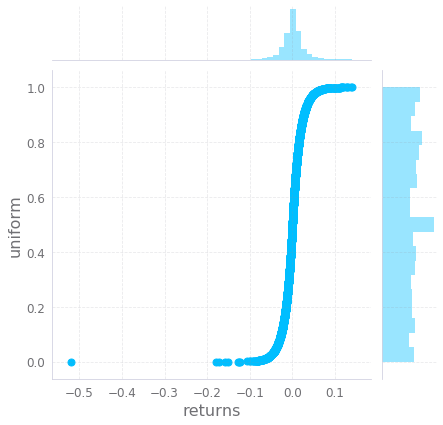

In [6]:
#visualizing transforming to uniform distribution with cdf
cdf_trans = sns.jointplot(returns, returns_trans, stat_func=None)
cdf_trans.set_axis_labels('returns', 'uniform', fontsize=16);

### Applying the Inverse CDF
Applying the inverse CDF (or the percent point function) to this transformed data, yields our original data on AAPL returns. This is how we're going to get our simulated data -- applying this inverse CDF to uniform marginals should give us a nice simulation of stock prices.

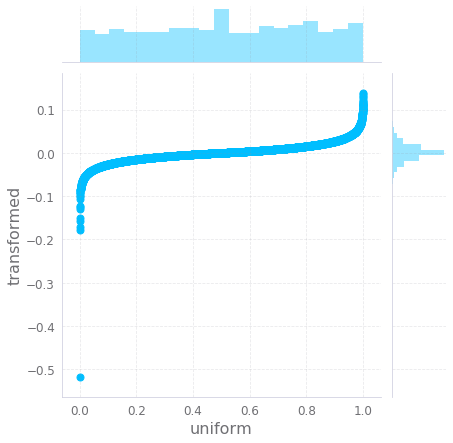

In [7]:
#visualizing transforming back to data with percent point function
returns_ppf = laplace.ppf(returns_trans)
ppf_trans = sns.jointplot(returns_trans, returns_ppf, stat_func=None)
ppf_trans.set_axis_labels('uniform', 'transformed', fontsize=16);
#demonstrates probability integral transform, both ways

## Visualizing the KDE for our Stock Data

Here, we visualize the KDE for our stock data, and see how it looks like after we transform it with the probability integral transform.

We plot the KDE for our stock returns data below.

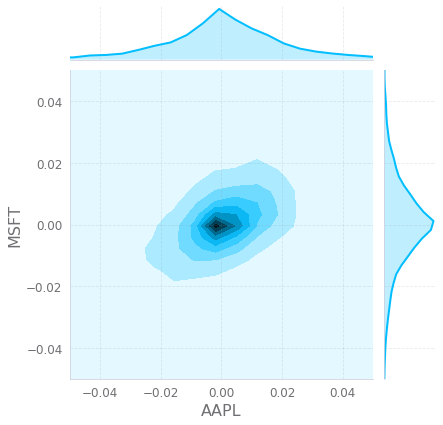

In [8]:
returns_kde = sns.jointplot(returns, returns_ms, kind='kde', stat_func=None);
returns_kde.ax_marg_x.set_xlim(-0.05,0.05)
returns_kde.ax_marg_y.set_ylim(-0.05,0.05)
returns_kde.set_axis_labels('AAPL', 'MSFT', fontsize=16);

Now, we apply the probability integral transform to both sets of data, and find that this isn't too great. It somewhat resembles the uniform marginals we want, if you ignore the huge spike in the centre. We can anticipate that the data we will simulate will not have the amount of kurtosis needed to accurately simulate our returns data.

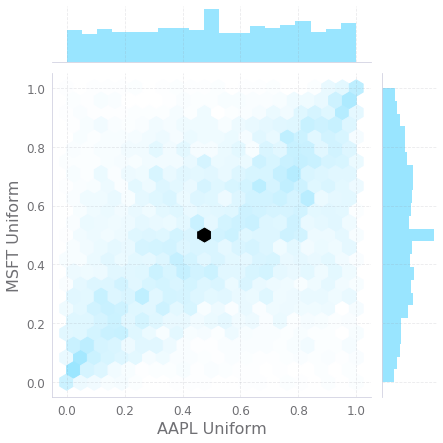

In [9]:
returns_unif = sns.jointplot(returns_trans, returns_ms_trans, kind='hex', stat_func=None)
returns_unif.set_axis_labels('AAPL Uniform', 'MSFT Uniform', fontsize=16);

## Generating Synthetic Data with the Gaussian Copula

Recall that to create synthetic data, we draw samples from a suitably-correlated multivariate normal distribution, apply the probability integral transform (the CDF of our normal distribution) to find uniform marginals, and apply the inverse CDF of the Laplace distributions we've fitted our stock data to to find synthetic stock returns. 

That is, elegantly described by StackExchange user `cardinal`, generate $(X,Y)$∼$N(0,\Sigma)$. Take $F^{−1}(\Phi(X))$ and $G^{−1}(\Phi(Y))$.

Let's create a multivariate Gaussian distribution with the correlation structure we want. We then plot its KDE.

[[1.         0.46154975]
 [0.46154975 1.        ]]


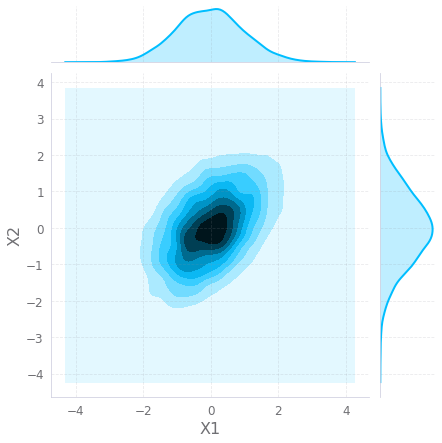

In [10]:
#getting simulated data
corr = np.corrcoef(returns, returns_ms)
print(corr)

mvnorm = stats.multivariate_normal(mean = [params[0], params_ms[0]], cov = corr)
x = mvnorm.rvs(5000)
h = sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);

We generate uniform marginals through applying the probability integral transform (here, the CDF of our normal distribution) to our samples from the multivariate normal distribution. 

Visualizing this, as we do here, corresponds to visualizing the density of the copula.

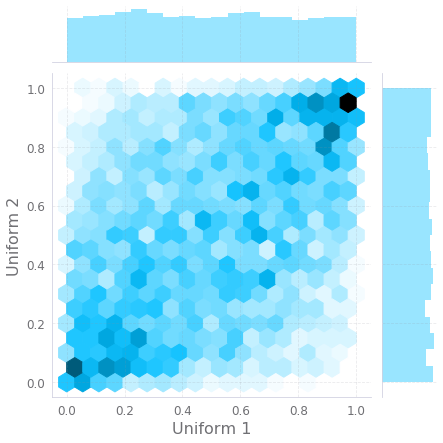

In [11]:
norm = stats.norm()
x_unif = norm.cdf(x)
sim_unif = sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)
sim_unif.set_axis_labels('Uniform 1', 'Uniform 2', fontsize=16);

Next, we apply the inverse CDFs of the Laplace distributions we fitted AAPL and MSFT data to, to each set of uniform marginals, and visualize the KDE of the result. We see that aside from lacking the kurtosis required, this looks pretty alright.

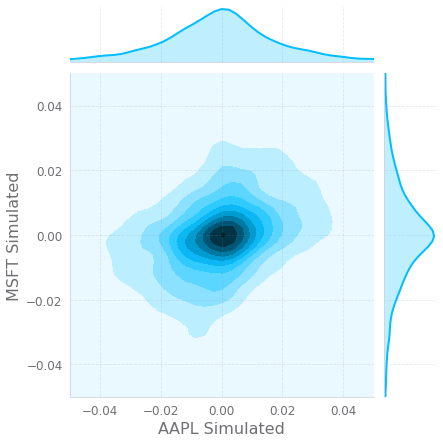

In [12]:
m1 = stats.laplace(params[0], params[1])
m2 = stats.laplace(params_ms[0], params_ms[1])

x1_trans = m1.ppf(x_unif[:, 0])
x2_trans = m2.ppf(x_unif[:, 1])

sim = sns.jointplot(x1_trans, x2_trans, kind='kde', xlim=(-0.05, 0.05), ylim=(-0.05, 0.05), stat_func=None);
sim.set_axis_labels('AAPL Simulated', 'MSFT Simulated', fontsize=16);

Finally, with StackOverflow user `CT Zhu`'s workaround, we display the final result. It doesn't look like a perfect fit, with tails that are too fat (arguably a great problem to have in finance with simulated data), a lack of kurtosis, and a possible over-estimate of the correlations (shrinkage may come in useful here). However, given the problems we've historically had with copulas in the Great Financial Crisis, these might possibly not be bad things.

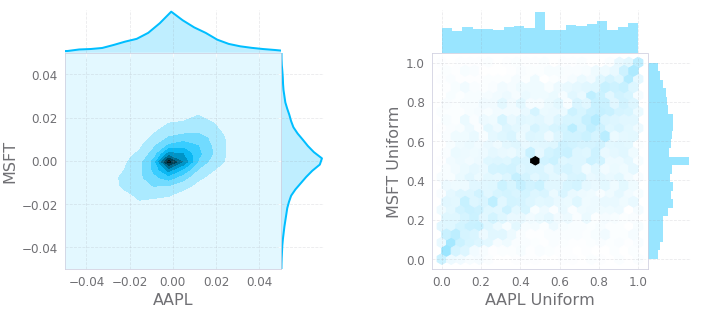

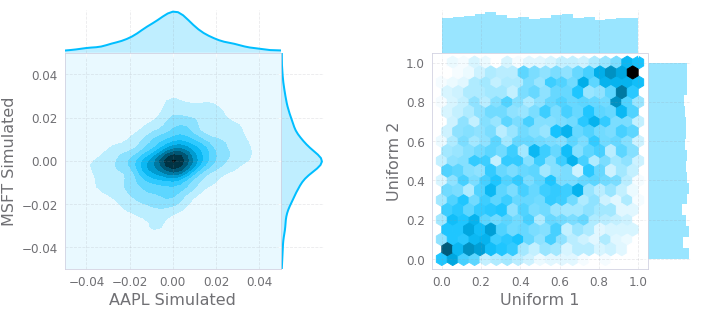

In [13]:
#subplots migration
f = plt.figure()
for plot in [returns_kde, returns_unif]:
    for A in plot.fig.axes:
        f._axstack.add(f._make_key(A), A)

#subplots size adjustment
f.axes[0].set_position([0.15, 0.1, 0.5,  0.5])
f.axes[1].set_position([0.15, 0.6, 0.5,  0.1])
f.axes[2].set_position([0.65, 0.1, 0.1, 0.5])
f.axes[3].set_position([1, 0.1, 0.5,  0.5])
f.axes[4].set_position([1, 0.6, 0.5,  0.1])
f.axes[5].set_position([1.5, 0.1, 0.1, 0.5])

#subplots migration
f = plt.figure()
for plot in [sim, sim_unif]:
    for A in plot.fig.axes:
        f._axstack.add(f._make_key(A), A)

#subplots size adjustment
f.axes[0].set_position([0.15, 0.1, 0.5,  0.5])
f.axes[1].set_position([0.15, 0.6, 0.5,  0.1])
f.axes[2].set_position([0.65, 0.1, 0.1, 0.5])
f.axes[3].set_position([1, 0.1, 0.5,  0.5])
f.axes[4].set_position([1, 0.6, 0.5,  0.1])
f.axes[5].set_position([1.5, 0.1, 0.1, 0.5])

A final sanity check with boilerplate code found on the `copulas` library's documentation, shows similar discrepancies with the synthetic data it generated on sample data. The first two sets of plots shows the effect on sample data, the second with our stock prices dataset.

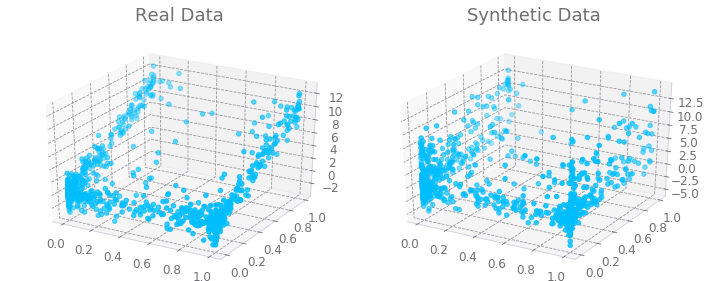

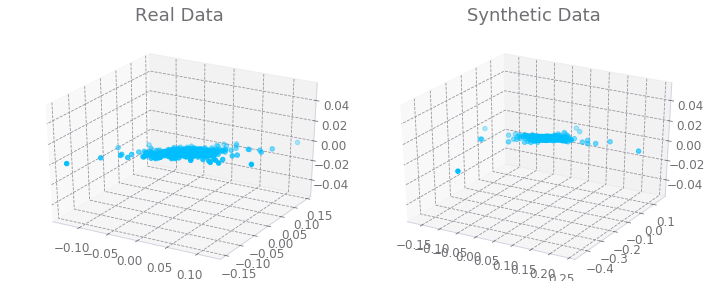

In [14]:
# sanity check with example code, found on copulas library documentation
# Load a dataset with 3 columns that are not independent

sample_data = sample_trivariate_xyz().fillna(0)
returns_data = pd.DataFrame({'AAPL': returns, 'MSFT': returns_ms}).iloc[-1000:-1, :]

for real_data in [sample_data, returns_data]:
    # Fit a gaussian copula to the data
    copula = GaussianMultivariate()
    copula.fit(real_data)

    # Sample synthetic data
    synthetic_data = copula.sample(len(real_data))

    # Plot the real and the synthetic data to compare
    compare_3d(real_data, synthetic_data)

## Conclusion

While generating synthetic data and modeling real trends with copulas can mean that one may run into issues, the problems may be beneficial in the right context. Possible extensions of this notebook may include non-Gaussian copulas.